In [1]:
from rm_case_3 import * # for data transformation
%matplotlib inline

In [2]:
data.head()

,object,date,rating,type
0,1,2012-07-01,E1,0
1,2,2012-07-01,E1,0
2,3,2012-07-01,E1,0
3,4,2012-07-01,E1,0
4,5,2012-07-01,E1,0


# 1. Введение

In [3]:
data['type'].unique()

array([0, 1, 2, 3, 4])

Types:    
1) contract expiration   
2) client broke the contract    
3) debt maturity    
4) M&A/liquidation    

## Определение события прекращения рейтингования      
Мы используем следующий подход к отзыву рейтингов:     
1. Если у объекта закончился контракт с рейтинговым агенством, либо он сам его разорвал, и если рейтингование продолжилось до конца окна исследования, такое наблюдение можно считать непрерванным и учесть как результат "эксперимента".    
2. Если же у объекта истек срок долга или же он был поглощен другой компанией, новый рейтинг агента нельзя считать рейтингом старого объекта, так как объект теперь совершенно новый. Такой объект мы не рассматриваем в рамках окна.   

# 2. ROC and CAP

In [4]:
year_1_starts, year_1_migration_matrix = build_migration_matrix(start_date = dt.datetime(day = 1, month = 7, year = 2012),
                                                                end_date = dt.datetime(day = 1, month = 7, year = 2013))

year_2_starts, year_2_migration_matrix = build_migration_matrix(start_date = dt.datetime(day = 1, month = 7, year = 2013),
                                                                end_date = dt.datetime(day = 1, month = 7, year = 2014))

year_3_starts, year_3_migration_matrix = build_migration_matrix(start_date = dt.datetime(day = 1, month = 7, year = 2014),
                                                                end_date = dt.datetime(day = 1, month = 7, year = 2015))

year_4_starts, year_4_migration_matrix = build_migration_matrix(start_date = dt.datetime(day = 1, month = 7, year = 2015),
                                                                end_date = dt.datetime(day = 1, month = 7, year = 2016))

year_5_starts, year_5_migration_matrix = build_migration_matrix(start_date = dt.datetime(day = 30, month = 6, year = 2016),
                                                                end_date = dt.datetime(day = 30, month = 6, year = 2017))

In [5]:
year_1_migration_matrix

,E1,E2,E3,E4,E5,E6,E7,E8,D
E1,59.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E2,0.0,84.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0
E3,3.0,4.0,106.0,3.0,6.0,1.0,0.0,0.0,5.0
E4,2.0,5.0,5.0,132.0,2.0,2.0,1.0,1.0,10.0
E5,0.0,0.0,1.0,4.0,63.0,5.0,5.0,0.0,9.0
E6,0.0,0.0,2.0,1.0,5.0,49.0,7.0,5.0,9.0
E7,0.0,1.0,0.0,0.0,3.0,4.0,40.0,9.0,12.0
E8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,27.0,22.0
D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### CAP Curve

In [6]:
class CAP_curve:
    
    def __init__(self, migration_matrix):
        self.migration_matrix = migration_matrix
        self.default_rates = migration_matrix['D'][::-1].cumsum()/migration_matrix['D'].sum()
        self.observation_rates = migration_matrix.sum(axis=1)[::-1].cumsum()/migration_matrix.sum(axis=1).sum()
        
    def AUC(self):
        sums_of_bases = np.array(self.default_rates)[:-1] + np.array(self.default_rates)[1:]
        heights = np.diff(np.array(cap_curve_1.observation_rates))
        return ((sums_of_bases / 2) * heights).sum()
    
    def __str__(self):
        return 'AUC-CAP: %s' % np.round(self.AUC(), 3)
    
    def ideal_AUC(self):
        return (1 - self.migration_matrix['D'].sum()/self.migration_matrix.sum().sum() + 1)/2 
        
def plot_CAP(CAP_curve):
    
    import matplotlib.patches as mpatches
    
    f = plt.figure(figsize=(10, 5))
    plt.title('CAP Curve')
    plt.xlabel('Observation Ratio') 
    plt.ylabel('Defaulters Ratio') 
    
    random_x = np.linspace(0,1,2)
    random_y = np.linspace(0,1,2)

    ideal_x = np.array([0, CAP_curve.migration_matrix['D'].sum()/CAP_curve.migration_matrix.sum().sum(), 1])
    ideal_y = np.array([0, 1, 1])
    
    plt.plot(random_x, random_y, color='b')
    plt.plot(ideal_x, ideal_y, color='r')
    plt.plot(CAP_curve.observation_rates, CAP_curve.default_rates, color='g')
           
    blue_patch = mpatches.Patch(color='blue', label='random model')
    red_patch = mpatches.Patch(color='red', label='best model')
    green_patch = mpatches.Patch(color='green', label='our model')
    
    plt.legend(handles=[red_patch, green_patch, blue_patch])
    
    plt.annotate(str(np.round(CAP_curve.migration_matrix['D'].sum()/CAP_curve.migration_matrix.sum().sum(), 3)), 
                 (CAP_curve.migration_matrix['D'].sum()/CAP_curve.migration_matrix.sum().sum(), 1),
                (CAP_curve.migration_matrix['D'].sum()/CAP_curve.migration_matrix.sum().sum()+0.05, 0.92), size=15);
    print(CAP_curve)
    print('Ideal AUC-CAP: %s' % np.round(CAP_curve.ideal_AUC(), 3))

AUC-CAP: 0.747
Ideal AUC-CAP: 0.952


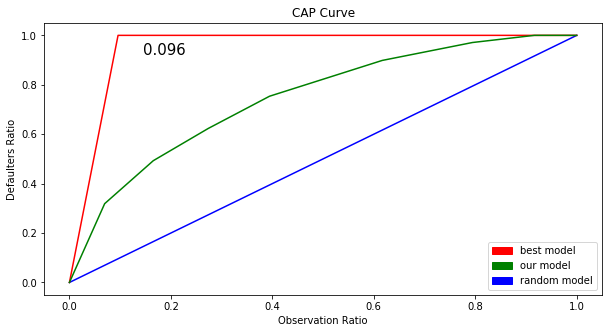

In [7]:
cap_curve_1 = CAP_curve(migration_matrix = year_1_migration_matrix)
plot_CAP(cap_curve_1)

AUC-CAP: 0.731
Ideal AUC-CAP: 0.942


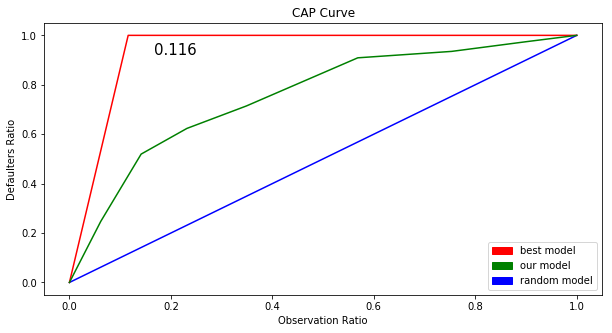

In [8]:
cap_curve_2 = CAP_curve(migration_matrix = year_2_migration_matrix)
plot_CAP(cap_curve_2)

AUC-CAP: 0.69
Ideal AUC-CAP: 0.961


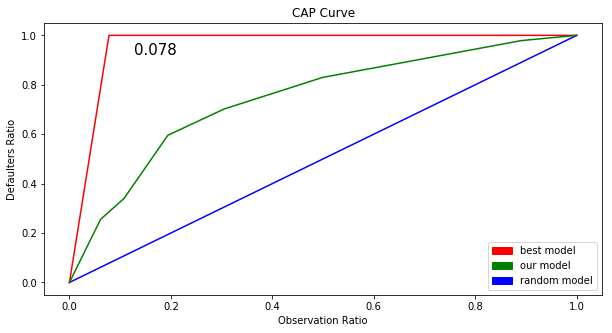

In [9]:
cap_curve_3 = CAP_curve(migration_matrix = year_3_migration_matrix)
plot_CAP(cap_curve_3)

AUC-CAP: 0.792
Ideal AUC-CAP: 0.968


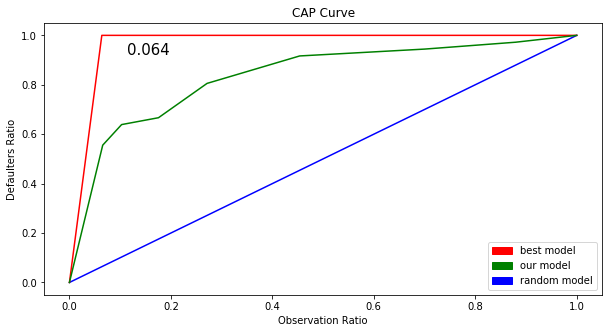

In [10]:
cap_curve_4 = CAP_curve(migration_matrix = year_4_migration_matrix)
plot_CAP(cap_curve_4)

AUC-CAP: 0.794
Ideal AUC-CAP: 0.986


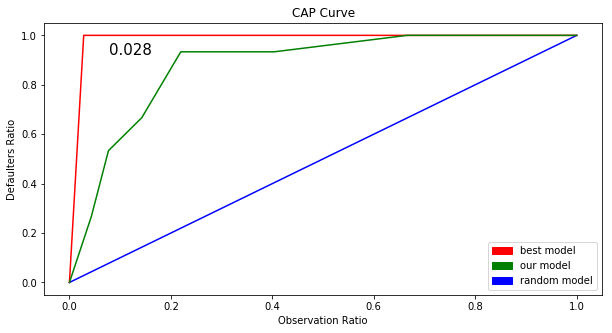

In [11]:
cap_curve_5 = CAP_curve(migration_matrix = year_5_migration_matrix)
plot_CAP(cap_curve_5)

### ROC Curve

In [12]:
class ROC_curve:
    
    def __init__(self, migration_matrix):
        
        self.migration_matrix = migration_matrix
        
        self.defaults = migration_matrix['D'][:-1]
        self.survived = migration_matrix.sum(axis=1)[:-1] - migration_matrix['D'][:-1]
        
        self.TP = np.array(self.survived.cumsum())
        self.FN = self.survived.sum() - self.TP
        self.TPR = np.append(0, self.TP / (self.TP + self.FN))
    
        self.FP = self.defaults.cumsum()
        self.TN = self.defaults.sum() - self.FP
        self.FPR = np.append(0, self.FP / (self.FP + self.TN)) 
        
    def AUC(self):
        sums_of_bases = np.array(self.TPR)[:-1] + np.array(self.TPR)[1:]
        heights = np.diff(np.array(self.FPR))
        return ((sums_of_bases / 2) * heights).sum()
    
    def __str__(self):
        return 'AUC-ROC: %s' % np.round(self.AUC(), 3)
        
def plot_ROC(ROC_curve):
    
    import matplotlib.patches as mpatches
    
    f = plt.figure(figsize=(10, 5))
    plt.title('ROC Curve')
    plt.xlabel('FPR') 
    plt.ylabel('TPR') 
    
    random_x = np.linspace(0,1,10)
    random_y = np.linspace(0,1,10)
    
    ideal_x = np.array([0, 0, 1])
    ideal_y = np.array([0, 1, 1])
    
    plt.plot(random_x, random_y, color='b')
    plt.plot(ideal_x, ideal_y, color='r')
    plt.plot(ROC_curve.FPR, ROC_curve.TPR, color='g')
           
    blue_patch = mpatches.Patch(color='blue', label='random model')
    red_patch = mpatches.Patch(color='red', label='ideal model')
    green_patch = mpatches.Patch(color='green', label='our model')
    
    plt.legend(handles=[red_patch, green_patch, blue_patch]);
    print(ROC_curve)

AUC-ROC: 0.773


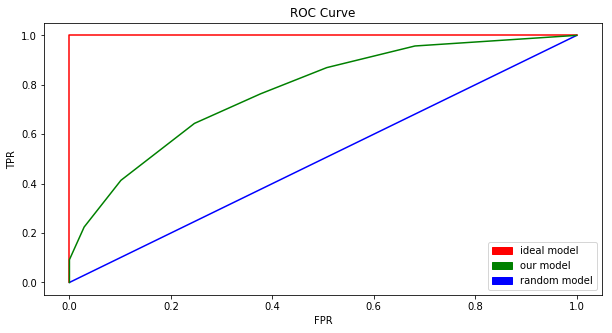

In [13]:
ROC_1 = ROC_curve(year_1_migration_matrix)
plot_ROC(ROC_1)

AUC-ROC: 0.789


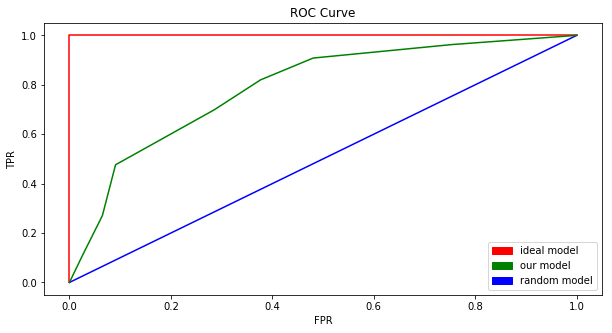

In [14]:
ROC_2 = ROC_curve(year_2_migration_matrix)
plot_ROC(ROC_2)

AUC-ROC: 0.766


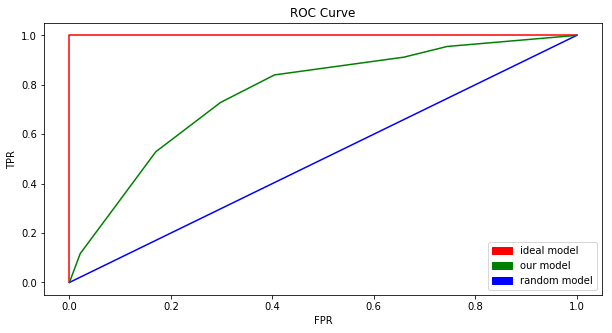

In [15]:
ROC_3 = ROC_curve(year_3_migration_matrix)
plot_ROC(ROC_3)

AUC-ROC: 0.858


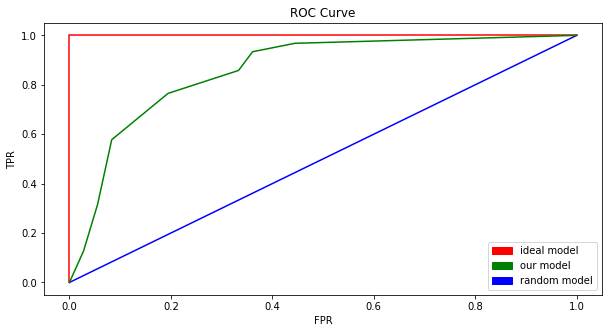

In [16]:
ROC_4 = ROC_curve(year_4_migration_matrix)
plot_ROC(ROC_4)

AUC-ROC: 0.891


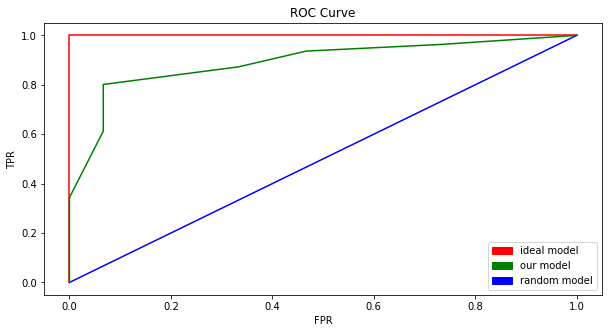

In [17]:
ROC_5 = ROC_curve(year_5_migration_matrix)
plot_ROC(ROC_5)

### Комментарии 
Рейтинговая система в целом показывает хорошую разделяющую способность как на дефолтеров, так и на надежных заемщиков. Площади под CAP и ROC кривой относительно близки к идеальным сценариям, при этом наилучшее качество достигается в последнем году. Рейтинговая система безусловно лучше случайного угадывания о качестве заемщика.

# 3. Матрицы миграций и матрицы переходных вероятностей

## Cohort method

In [18]:
year_1_probability_matrix = build_transition_probability_matrix(migration_matrix = year_1_migration_matrix, 
                                                                 start_vector = year_1_starts)

year_2_probability_matrix = build_transition_probability_matrix(migration_matrix = year_2_migration_matrix, 
                                                                 start_vector = year_2_starts)

year_3_probability_matrix = build_transition_probability_matrix(migration_matrix = year_3_migration_matrix, 
                                                                 start_vector = year_3_starts)

year_4_probability_matrix = build_transition_probability_matrix(migration_matrix = year_4_migration_matrix, 
                                                                 start_vector = year_4_starts)

year_5_probability_matrix = build_transition_probability_matrix(migration_matrix = year_5_migration_matrix, 
                                                                 start_vector = year_5_starts)

/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Риск-менеджмент/Кейс 2/Risk-Management/rm_case_3.py:63: RuntimeWarning: invalid value encountered in true_divide
  matrix = (np.matrix(migration_matrix).T / np.array(start_vector)).T


In [19]:
year3_1_starts, year3_1_migration_matrix = build_migration_matrix(start_date = dt.datetime(day = 1, month = 7, year = 2012), 
                                                                  end_date = dt.datetime(day = 1, month = 7, year = 2015))

year3_2_starts, year3_2_migration_matrix = build_migration_matrix(start_date = dt.datetime(day = 1, month = 7, year = 2013), 
                                                                  end_date = dt.datetime(day = 1, month = 7, year = 2016))

year3_3_starts, year3_3_migration_matrix = build_migration_matrix(start_date = dt.datetime(day = 1, month = 7, year = 2014), 
                                                                  end_date = dt.datetime(day = 1, month = 7, year = 2017))

In [20]:
year3_1_probability_matrix = build_transition_probability_matrix(migration_matrix = year3_1_migration_matrix, 
                                                                 start_vector = year3_1_starts)

year3_2_probability_matrix = build_transition_probability_matrix(migration_matrix = year3_2_migration_matrix, 
                                                                 start_vector = year3_2_starts)

year3_3_probability_matrix = build_transition_probability_matrix(migration_matrix = year3_3_migration_matrix, 
                                                                 start_vector = year3_3_starts)

In [21]:
year3_2_probability_matrix

,E1,E2,E3,E4,E5,E6,E7,E8,D
E1,0.861538,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.061538
E2,0.074468,0.755319,0.085106,0.021277,0.000000,0.000000,0.000000,0.000000,0.063830
E3,0.032787,0.040984,0.778689,0.081967,0.016393,0.000000,0.000000,0.000000,0.049180
E4,0.007576,0.075758,0.083333,0.515152,0.045455,0.007576,0.015152,0.022727,0.227273
E5,0.000000,0.000000,0.054795,0.109589,0.328767,0.150685,0.013699,0.054795,0.287671
E6,0.000000,0.000000,0.000000,0.052632,0.052632,0.333333,0.140351,0.052632,0.368421
E7,0.000000,0.000000,0.000000,0.019231,0.000000,0.019231,0.076923,0.096154,0.788462
E8,0.000000,0.000000,0.000000,0.000000,0.000000,0.097561,0.048780,0.170732,0.682927
D,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [22]:
year_2_probability_matrix @ year_3_probability_matrix @ year_4_probability_matrix

,E1,E2,E3,E4,E5,E6,E7,E8,D
E1,0.847553,0.091189,0.002454,0.000032,0.000019,0.000000,0.000000,0.000000,0.013769
E2,0.060743,0.764384,0.083182,0.018118,0.002571,0.000128,0.000157,0.000415,0.010297
E3,0.041460,0.048703,0.750822,0.066283,0.028260,0.001185,0.000367,0.003961,0.013433
E4,0.015591,0.049857,0.094110,0.548697,0.043641,0.014909,0.010167,0.018359,0.048063
E5,0.002965,0.013820,0.054491,0.098691,0.339241,0.126189,0.032911,0.069161,0.086449
E6,0.000121,0.001075,0.001998,0.028876,0.067538,0.355158,0.087434,0.070597,0.071512
E7,0.000330,0.000909,0.001190,0.016598,0.019790,0.041398,0.133175,0.116944,0.146167
E8,0.000000,0.000000,0.000000,0.002923,0.004661,0.059240,0.031438,0.118938,0.154348
D,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [23]:
abs(year3_2_probability_matrix - year_2_probability_matrix @ year_3_probability_matrix @ year_4_probability_matrix)

,E1,E2,E3,E4,E5,E6,E7,E8,D
E1,0.013986,0.014266,0.002454,0.000032,0.000019,0.000000,0.000000,0.000000,0.047770
E2,0.013725,0.009065,0.001924,0.003159,0.002571,0.000128,0.000157,0.000415,0.053533
E3,0.008673,0.007719,0.027867,0.015684,0.011866,0.001185,0.000367,0.003961,0.035747
E4,0.008015,0.025900,0.010777,0.033545,0.001814,0.007333,0.004984,0.004368,0.179210
E5,0.002965,0.013820,0.000304,0.010898,0.010474,0.024496,0.019213,0.014367,0.201223
E6,0.000121,0.001075,0.001998,0.023756,0.014906,0.021824,0.052917,0.017965,0.296909
E7,0.000330,0.000909,0.001190,0.002632,0.019790,0.022167,0.056252,0.020790,0.642294
E8,0.000000,0.000000,0.000000,0.002923,0.004661,0.038321,0.017343,0.051794,0.528579
D,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Оценки отличаются, потому что построены на разном множестве наблюдений. Оценка, построенная по большему множеству наблюдений, должна быть точнее, поэтому из двух матриц лучше пользоваться той, которая получается перемножением. С другой стороны, у этой матрицы вероятности дефолта существенно ниже, чем у трехлетней матрицы, что настораживает.

Можно также заметить, что оценки вероятностей переходов, полученные когортным методов, содержат нулевые элементы, что не соответствует реальности.

## Duration method

In [24]:
year_1_duration_migration = build_duration_migration_matrix(start_date = dt.datetime(day = 1, month = 7, year = 2012),
                                                            end_date = dt.datetime(day = 1, month = 7, year = 2013))
year_2_duration_migration = build_duration_migration_matrix(start_date = dt.datetime(day = 1, month = 7, year = 2013),
                                                            end_date = dt.datetime(day = 1, month = 7, year = 2014))
year_3_duration_migration = build_duration_migration_matrix(start_date = dt.datetime(day = 1, month = 7, year = 2014),
                                                            end_date = dt.datetime(day = 1, month = 7, year = 2015))
year_4_duration_migration = build_duration_migration_matrix(start_date = dt.datetime(day = 1, month = 7, year = 2015),
                                                            end_date = dt.datetime(day = 1, month = 7, year = 2016))
year_5_duration_migration = build_duration_migration_matrix(start_date = dt.datetime(day = 30, month = 6, year = 2016),
                                                            end_date = dt.datetime(day = 1, month = 7, year = 2017))

year3_1_duration_migration = build_duration_migration_matrix(start_date = dt.datetime(day = 1, month = 7, year = 2012),
                                                             end_date = dt.datetime(day = 1, month = 7, year = 2015))
year3_2_duration_migration = build_duration_migration_matrix(start_date = dt.datetime(day = 1, month = 7, year = 2013),
                                                             end_date = dt.datetime(day = 1, month = 7, year = 2016))
year3_3_duration_migration = build_duration_migration_matrix(start_date = dt.datetime(day = 1, month = 7, year = 2014),
                                                             end_date = dt.datetime(day = 1, month = 7, year = 2017))

In [25]:
year_1_generator = build_generator_matrix(year_1_duration_migration)
year_2_generator = build_generator_matrix(year_2_duration_migration)
year_3_generator = build_generator_matrix(year_3_duration_migration)
year_4_generator = build_generator_matrix(year_4_duration_migration)
year_5_generator = build_generator_matrix(year_5_duration_migration)

year3_1_generator = build_generator_matrix(year3_1_duration_migration)
year3_2_generator = build_generator_matrix(year3_2_duration_migration)
year3_3_generator = build_generator_matrix(year3_3_duration_migration)

In [26]:
year_1_exponential = build_matrix_exponential(year_1_generator)
year_2_exponential = build_matrix_exponential(year_2_generator)
year_3_exponential = build_matrix_exponential(year_3_generator)
year_4_exponential = build_matrix_exponential(year_4_generator)
year_5_exponential = build_matrix_exponential(year_5_generator)

year3_1_exponential = build_matrix_exponential(year3_1_generator)
year3_2_exponential = build_matrix_exponential(year3_2_generator)
year3_3_exponential = build_matrix_exponential(year3_3_generator)

In [30]:
year3_2_exponential

,E1,E2,E3,E4,E5,E6,E7,E8,D
E1,0.854248,0.082978,0.004238,0.000807,0.000088,0.000013,0.000006,0.000012,0.057611
E2,0.055611,0.772815,0.080046,0.015590,0.002369,0.000415,0.000176,0.000349,0.072630
E3,0.036639,0.048076,0.753121,0.058729,0.032536,0.004850,0.001966,0.002795,0.061289
E4,0.015706,0.048864,0.097798,0.556755,0.045326,0.022727,0.009304,0.020869,0.182650
E5,0.002946,0.021515,0.056449,0.080249,0.360288,0.104580,0.039563,0.048676,0.285733
E6,0.000366,0.002122,0.005247,0.023738,0.057270,0.358976,0.076090,0.076248,0.399942
E7,0.000109,0.000989,0.002660,0.005319,0.033898,0.059943,0.120164,0.149564,0.627354
E8,0.000015,0.000107,0.000274,0.001424,0.004639,0.039546,0.015588,0.131509,0.806897
D,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Подобная оценка выглядит куда приятнее, чем когортным методом.

In [29]:
abs(year3_2_exponential - year_2_probability_matrix @ year_3_probability_matrix @ year_4_probability_matrix)

,E1,E2,E3,E4,E5,E6,E7,E8,D
E1,0.006695,0.008212,0.001784,0.000775,0.000069,0.000013,0.000006,0.000012,0.043842
E2,0.005133,0.008431,0.003136,0.002528,0.000202,0.000286,0.000019,0.000067,0.062333
E3,0.004821,0.000627,0.002299,0.007554,0.004276,0.003664,0.001599,0.001167,0.047856
E4,0.000116,0.000993,0.003687,0.008059,0.001686,0.007818,0.000863,0.002510,0.134588
E5,0.000019,0.007695,0.001958,0.018442,0.021047,0.021609,0.006652,0.020485,0.199285
E6,0.000245,0.001047,0.003249,0.005137,0.010268,0.003819,0.011343,0.005651,0.328430
E7,0.000221,0.000080,0.001470,0.011279,0.014107,0.018545,0.013011,0.032619,0.481187
E8,0.000015,0.000107,0.000274,0.001499,0.000021,0.019694,0.015850,0.012571,0.652549
D,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Excel Export

In [39]:
starts = [year_1_starts, year_2_starts, year_3_starts, year_4_starts, year_5_starts]

migrations = [year_1_migration_matrix, year_2_migration_matrix, year_3_migration_matrix, year_4_migration_matrix, year_5_migration_matrix]

probabilities = [year_1_probability_matrix, year_2_probability_matrix, year_3_probability_matrix, year_4_probability_matrix, year_5_probability_matrix]

i = 0

starts_writer = pd.ExcelWriter('Starts_in_categories.xlsx', engine = 'openpyxl')
matrix_writer = pd.ExcelWriter('Transition_matricies.xlsx', engine = 'openpyxl')
probability_writer = pd.ExcelWriter('Probability_cohort_matricies.xlsx', engine = 'openpyxl')

for start, matrix, probability in zip(starts, migrations, probabilities):
    i += 1
    start.to_excel(starts_writer, sheet_name='Year ' + str(i))
    matrix.to_excel(matrix_writer, sheet_name='Year ' + str(i))
    probability.to_excel(probability_writer, sheet_name='Year '  + str(i))
    
starts_writer.save()
matrix_writer.save()
probability_writer.save()